PyTorch provides the elegantly designed modules and classes `torch.nn` , `torch.optim` , `Dataset` , and `DataLoader` to help us create and train neural networks. In order to fully utilize their power and customize them for our problem, we need to **really** understand exactly what they’re doing.

To develop this understanding, 
- we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. 
- Then, we will incrementally add one feature from `torch.nn`, `torch.optim`, `Dataset`, or `DataLoader` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

## MNIST data setup

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them.

In [2]:
from pathlib import Path
import requests

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). 

Let’s take a look at one; we need to reshape it to 2d first.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

(50000, 784)


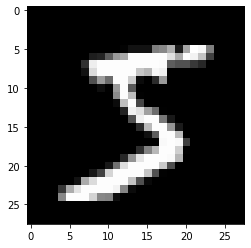

In [6]:
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
print(x_train.shape)

PyTorch uses `torch.tensor` instead of numpy arrays. So we need to convert the data

In [7]:
import torch

In [8]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

In [9]:
print(x_train, y_train)
print(f"Shape of training data: {x_train.shape}")
print(f"min label: {y_train.min()}, max label: {y_train.max()}")

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
Shape of training data: torch.Size([50000, 784])
min label: 0, max label: 9


## Neural net from scratch (no torch.nn)

Let’s first create a model using nothing but PyTorch tensor operations.

Note: We are initializing the weights here with [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialisation (by multiplying with 1/sqrt(n)).

In [10]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! Here we write a plain matrix multiplication and broadcasted addition to create a simple linear model.

For activation function we'll write *log_softmax*.
(Although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.)

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [12]:
x = torch.tensor([1.0,2,3,4])
x - x.exp()

tensor([ -1.7183,  -5.3891, -17.0855, -50.5981])

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [13]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], preds.shape

(tensor([-1.7520, -2.1178, -1.9868, -2.7721, -2.1494, -2.4752, -2.4750, -2.6911,
         -2.3647, -2.8141], grad_fn=<SelectBackward>), torch.Size([64, 10]))

Let's implement negative log-likelihood as the loss function:

In [14]:
def neg_log_lik(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_fn = neg_log_lik

Loss with our random model:

In [15]:
yb = y_train[0:bs]
loss_fn(preds, yb)

tensor(2.3094, grad_fn=<NegBackward>)

Calculate the accuracy of the model: For each prediction, if the index with the largest value matches the target value, then the prediction was correct.



In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

accuracy(preds, yb)

tensor(0.1719)

We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size `bs`)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, `weights` and `bias`.

Note:
- By using gradients to update the weights and bias, we do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient.

- We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

In [17]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        if i % 50 == 0:
            print(f"[epoch {epoch + 1}, iter {i}]: {loss}")

        loss.backward()

        with torch.no_grad():
            # update weights
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # zero grad for next loop
            weights.grad.zero_()
            bias.grad.zero_()




[epoch 1, iter 0]: 2.3093509674072266
[epoch 1, iter 50]: 0.4197274446487427
[epoch 1, iter 100]: 0.3120243549346924
[epoch 1, iter 150]: 0.28343045711517334
[epoch 1, iter 200]: 0.300825834274292
[epoch 1, iter 250]: 0.5515051484107971
[epoch 1, iter 300]: 0.3799591064453125
[epoch 1, iter 350]: 0.3051801323890686
[epoch 1, iter 400]: 0.23816058039665222
[epoch 1, iter 450]: 0.21838515996932983
[epoch 1, iter 500]: 0.3832177519798279
[epoch 1, iter 550]: 0.35959625244140625
[epoch 1, iter 600]: 0.2618858218193054
[epoch 1, iter 650]: 0.24013422429561615
[epoch 1, iter 700]: 0.3840702474117279
[epoch 1, iter 750]: 0.2189883291721344
[epoch 2, iter 0]: 0.27328863739967346
[epoch 2, iter 50]: 0.33668485283851624
[epoch 2, iter 100]: 0.2601320445537567
[epoch 2, iter 150]: 0.2008134424686432
[epoch 2, iter 200]: 0.19638781249523163
[epoch 2, iter 250]: 0.4840746223926544
[epoch 2, iter 300]: 0.33805814385414124
[epoch 2, iter 350]: 0.2569262385368347
[epoch 2, iter 400]: 0.211709022521972

In [18]:
print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08314824104309082
accuracy: 1.0


That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

## Using `torch.nn.functional`

Now we refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s `nn` classes to make it more concise and flexible.

- Replace our hand-written activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention)
    - If we're using negative log likelihood and log softmax activation, we can use `F.cross_entropy` that combines these two. So we can even remove the activation function from our model.

In [19]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

def model(xb):
    return xb @ weights + bias # No call log_softmax in the model

In [20]:
print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.083148293197155
accuracy: 1.0


## Refactor using `nn.Module`

Now we'll use `nn.Module` and `nn.Parameter` for a clearer and more concise training loop. Subclassing `nn.Module`, we create a class that holds our weights, biasm and method for the forward step.

In [21]:
from torch import nn

class Mnist_Logistic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias


In [22]:
model = Mnist_Logistic()

`nn.Module` objects are used as if they are functions (i.e they are *callable*), but behind the scenes Pytorch will call our `forward` method automatically.



In [23]:
print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 2.3011975288391113
accuracy: 0.0625


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which are both defined by PyTorch for `nn.Module`) to make those steps more concise and less prone to the error of forgetting some of our parameters

```python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr 
    model.zero_grad()
```

Now let's wrap our training loop in a `fit()` function:

In [24]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [25]:
# Print and check the result
print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08175675570964813
accuracy: 1.0


## Refactor using `nn.Linear`

Instead of manually defining and initializing `self.weights` and `self.bias`, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [26]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [27]:
model = Mnist_Logistic()
print(loss_fn(model(xb), yb))

tensor(2.4157, grad_fn=<NllLossBackward>)


In [28]:
fit()

print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08121129870414734
accuracy: 1.0


## Refactor using `optim`

Pytorch also has a package with various optimization algorithms, `torch.optim`. We can use the `step` method from our optimizer to take a forward step, instead of manually updating each parameter.

(`optim.zero_grad()` resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)



In [29]:
from torch import optim

In [30]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_fn(model(xb), yb))

tensor(2.3672, grad_fn=<NllLossBackward>)


In [31]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08056163787841797
accuracy: 1.0


## Refactor using `Dataset`

PyTorch has an abstract Dataset class. A Dataset can be anything that has

- `__len__` function
- `__getitem__` function 

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [32]:
from torch.utils.data import TensorDataset

Both `x_train` and `y_train` can be combined in a single `TensorDataset`, which will be easier to iterate over and slice.

In [33]:
train_ds = TensorDataset(x_train, y_train)

Previously we had to iterate through mini-batches of x and y values separately

```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end:i]
```

Now we can do these two steps together:

```python
xb, yb = train_ds[i*bs : i*bs+bs]
```

In [34]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08123419433832169
accuracy: 1.0


## Refactor using DataLoader

PyTorch's `DataLoader` is responsible for managing batches. We can create a `DataLoader` from any `Dataset`. Rather than having to use `train_ds[i*bs : i*bs+bs]`, the DataLoader gives us each minibatch automatically.

In [35]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:

```python
for xb, yb in train_dl:
    pred = model(xb)
```

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(f"loss: {loss_fn(model(xb), yb)}")
print(f"accuracy: {accuracy(model(xb), yb)}")

loss: 0.08228730410337448
accuracy: 1.0


Now our training loop is dramatically smaller and easier to understand!

## Add Validation

In order to identify overfitting, we always should also have a **validation set**

**Shuffling the training data** is important to prevent correlation between batches and overfitting. 
On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, **it makes no sense to shuffle the validation data**.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [37]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

Now we will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [38]:
model, opt = get_model()

for epoch in range(epochs):
    model.train() # call before training
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb) for xb, yb in valid_dl)
    print(f"{epoch}: {valid_loss / len(valid_dl)}")

0: 0.3795289993286133
1: 0.303415447473526


## Create `fit()` and `get_data()`

Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, `loss_batch`, which computes the loss for one batch.

- For training set, we pass an optimizer in and use it to perform backprop

- For validation set, we don't pass any optimizer, so the methdo doesn't perform backprop



In [39]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)

    # only perform backprop when for training set 
    # (i.e., an optimizer is specified)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

`fit` runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [40]:
import numpy as np

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_fn, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [41]:
def get_data(train_ds, valid_ds, bs):
    """
    returns dataloaders for the training and validation sets
    """
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [42]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3262045997142792
1 0.38030795736312867


## Switch to CNN

Let's see if we can use these 3 lines of code to train a CNN.

We are going to build our neural network with 3 convolutional layers
- We will use PyTorch's predefined `Conv2d` class as our convolutional layer
- Each convolutional is followed by a ReLU

At the end, we perform an average pooling.

In [43]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # view() is PyTorch's version of numpy's reshape
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


In [44]:
lr = 0.1
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3182771824061871
1 0.24366851032972336


`nn.Sequential`

`torch.nn` has another handy class to simply our code: `Sequential`. A `Sequential` object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a **custom layer** from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network.

In [45]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)


In [46]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),   
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3751671949386597
1 0.28894034023284915


## Wrapping DataLoader

Currently our CNN only works with MNIST, because
- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. 

First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [47]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace `nn.AvgPool2d` with `nn.AdaptiveAvgPool2d`, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [48]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [49]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.35094336054325104
1 0.2842182375431061


## Using your GPU

First, check if our GPU is working in PyTorch:

In [50]:
torch.cuda.is_available()

True

Then create a device object for it:

In [51]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now let's update `preprocess` to move batches to the GPU:

In [52]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

And finally we can move our model to the GPU:

In [53]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Our training should run faster now:

In [54]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.243453067946434
1 0.17341095190346242
